<a href="https://colab.research.google.com/github/warshauer/py895_quickDraw/blob/main/ML_QD_trainer_JiiNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [ ]:
from __future__ import print_function
import keras,sklearn
# suppress tensorflow compilation warnings
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import tensorflow.compat.v1 as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
seed=0
np.random.seed(seed) # fix random seed
tf.set_random_seed(seed)
import matplotlib.pyplot as plt
import cv2
import pickle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from urllib.request import urlopen 
import requests
import io
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
all_cat_titles = ['airplane','monalisa','dragon','giraffe','axe','banana','eiffeltower','snail','windmill','snowman','schoolbus','smileyface','lollipop',]

img_rows, img_cols = 28, 28 

use_dataset_titles = ['X_use','Y_use']
ONLYFORFINALCOMPARATIVETEST_DATASETS_DONTYOUFUCKINGTOUCHTHESE = ['X_onlytest','Y_onlytest']
#DONT YOU DARE TOUCH THE ONLYTEST FILES.
#IF YOU ARE TRAINING A NEURAL NETWORK, TRAIN, VALIDATE, AND TEST FROM THE 'USE' FILES.

#load data
url_main = 'https://physics.bu.edu/~warsh/ML_QD/'
datalib={}

#loading samples
response = requests.get(url_main + use_dataset_titles[0] +'.npy')
response.raise_for_status()
data = np.load(io.BytesIO(response.content), allow_pickle=False)
data = data.reshape(data.shape[0], img_rows*img_cols)
datalib[use_dataset_titles[0]] = data

response = requests.get(url_main + use_dataset_titles[1] +'.npy')
response.raise_for_status()
data = np.load(io.BytesIO(response.content), allow_pickle=False)
datalib[use_dataset_titles[1]] = data

num_classes = int(max(datalib['Y_use'])+1)
cat_titles = all_cat_titles[:num_classes]
print('loaded:',cat_titles)

loaded: ['airplane', 'monalisa', 'dragon', 'giraffe', 'axe', 'banana', 'eiffeltower', 'snail', 'windmill', 'snowman']


an example of a data point with label banana


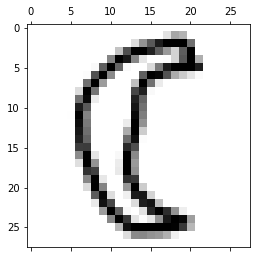

an example of a data point with label airplane


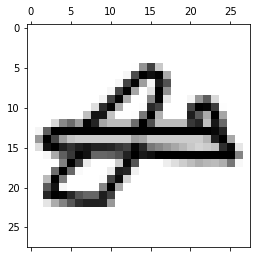

X_train shape: (863148, 28, 28, 1)
Y_train shape: (863148, 10)
X_valid shape: (215787, 28, 28, 1)
Y_valid shape: (215787, 10)
X_test shape: (269734, 28, 28, 1)
Y_test shape: (269734, 10)

863148 train samples
215787 validation samples
269734 test samples
1348669 total


In [ ]:
Y_use = datalib['Y_use']
X_use = datalib['X_use']

#format, delegate, and scale data
ratio_use=1
#use small portion, randomized already:
numosamps = len(Y_use)*ratio_use #number of samples used for train, validation, and testsets
test_size=.2 #20% test
tr2valr=.8 #64% train, 16% validation
num_classes=int(max(Y_use)+1)

#scramble and split!
X_tr, X_test, Y_tr, Y_test = train_test_split(X_use, Y_use, test_size=test_size, train_size=1.0-test_size)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_tr,Y_tr,train_size=tr2valr,test_size=1-tr2valr)

#how much we usin'
X_train = X_train[0:int(numosamps*(1.0-test_size)*tr2valr)]
Y_train = Y_train[0:int(numosamps*(1.0-test_size)*tr2valr)]
X_valid = X_valid[0:int(numosamps*(1.0-test_size)*(1.0-tr2valr))]
Y_valid = Y_valid[0:int(numosamps*(1.0-test_size)*(1.0-tr2valr))]
X_test = X_test[0:int(numosamps*test_size)]
Y_test = Y_test[0:int(numosamps*test_size)]

#reshape into 2D
X_train = X_train.reshape(X_train.shape[0],img_rows,img_cols)
X_valid = X_valid.reshape(X_valid.shape[0],img_rows,img_cols)
X_test = X_test.reshape(X_test.shape[0],img_rows,img_cols)

#yeah okay some floats
X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
X_test = X_test.astype('float32')

#scale onto the fun zer-O to O-ne inverval
X_train /= 255
X_valid /= 255
X_test /= 255

#display some stuff
for i in range(2):
    print('an example of a data point with label', cat_titles[int(Y_train[i])])
    plt.matshow(X_train[i,:],cmap='binary')
    plt.show()

# converting the actual numbers to the the one-hot vectors
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
Y_valid = keras.utils.to_categorical(Y_valid, num_classes)

#reshape data, depending on Keras backend, final data formatting
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    X_valid = X_valid.reshape(X_valid.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    X_valid = X_valid.reshape(X_valid.shape[0], img_rows, img_cols,1)
    input_shape = (img_rows, img_cols, 1)

#more debugging shit
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_valid shape:', X_valid.shape)
print('Y_valid shape:', Y_valid.shape)
print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_valid.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')

print(X_train.shape[0]+X_valid.shape[0]+X_test.shape[0], 'total')

In [ ]:
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

# Function to create model, required for KerasClassifier
def create_model():
    # instantiate model
    model = Sequential()
    # add first convolutional layer with 10 filters (dimensionality of output space)
    model.add(Conv2D(64, kernel_size=(3, 3), strides = 1,
                     activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(3, 3), strides = 2, padding='same'))
    # apply dropout with rate 0.4
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    # apply dropout with rate 0.4
    model.add(Dropout(0.2))
    
    # flatten data
    model.add(Flatten())
    # add a dense all-to-all relu layer
    model.add(Dense(800, activation='relu'))
    model.add(Dropout(0.4))
    # soft-max layer
    model.add(Dense(num_classes, activation='softplus'))
    
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='Adam',
                  metrics=['accuracy'])
    #lil something special to show us our architecture traits
    model.summary()
    print('Model is compiled and ready to train!')
    return model 
    

In [ ]:
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=2)
grid_result = grid.fit(X_train, Y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
#create model
model = KerasClassifier(build_fn=create_model, epochs=5, batch_size=100, verbose=0)
# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, Y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 32)        18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

In [ ]:
# create model
model = KerasClassifier(build_fn=create_model, epochs=5, batch_size=100, verbose=0)
# define the grid search parameters
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, Y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 32)        18464     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)             

In [ ]:
# create model
model = KerasClassifier(build_fn=create_model, epochs=5, batch_size=100, verbose=0)
# define the grid search parameters
neurons = [1, 5, 10, 15, 20, 25, 30, 32, 64]
param_grid = dict(neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, Y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2304)             

In [ ]:
modelname='JiiNet'

# training parameters
batch_size = 500
epochs = 30

# create the deep conv net
model_CNN=create_model()

# train CNN
model_CNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_valid, Y_valid))

#evaluate model
score = model_CNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
model_CNN.save('JiiNet_SoftPlus_500B_30E.h5') 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#loading trained models to evaluate on the same test sets and compare, make sure your paths are chill before running
#totally also make sure you scramble the test part of the X_use and Y_use before you compare otherwise thats just not chill bro.
#also dont you dare touch my special only touch datasets, we save those bad boys for when we compare our final trained models

#load from local drive
#filedir = '/content/gdrive/My Drive/'
#modelfile = 'JiiNet_SoftMax.h5'
#SoftMax = load_model(filedir+modelfile)

#load from local drive
modelfile = 'JiiNet_SoftPlus_500B_30E.h5'
SoftPlus = load_model(modelfile)

#evaluate models - note: loaded test set must have same expected samples as the trained set
SoftPlus_score = SoftPlus.evaluate(X_test, Y_test, verbose=1)
#SoftMax_score = SoftMax.evaluate(X_test, Y_test, verbose=1)
print('                 SoftPlus                      SoftMax')
print('    Test loss: %.8f'%SoftPlus_score[0])#+ '    '+ '%.12f'%SoftMax_score[0])
print('Test accuracy: %.12f'%SoftPlus_score[1])#+ '    ' + '%.12f'%SoftMax_score[1])

8430/8430 [==============================] - 18s 2ms/step - loss: 0.1289 - accuracy: 0.9684
                 SoftPlus                      SoftMax
    Test loss: 0.12891209
Test accuracy: 0.968435585499
